In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%pylab inline

In [45]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import torch
import torch.nn as nn
import torchvision
import numpy as np
from matplotlib import pyplot
from torchsummary import summary
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

import sys
sys.path.append("../src/")
import model
import dataset
import config
from utils.function import init_logging, init_environment, preprocess_image,\
         recreate_image, get_lr, save_image

In [5]:
# hyper parameter
resume = "001-215"
model_dir = "/data15/jiaxin/Interpretation/saved/models"
backbone = "convNet"
#generated_dir = 
#selected_layer = configs_dict["selected_layer"]
#selected_filter = configs_dict["selected_filter"]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
# model
net = model.Network(backbone=backbone)
net.to(device)

Network(
  (model): convNet(
    (features): Sequential(
      (0): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (fc): Sequential(
      (0): Linear(in_features=800, out_features=500, bias=True)
      (1): ReLU()
      (2): Linear(in_features=500, out_features=10, bias=True)
    )
  )
)

In [7]:
# resume from model
resume_exp = resume.split("-")[0]
resume_epoch = resume.split("-")[1]
print("Resume from model from exp: {} at epoch {}".format(resume_exp, resume_epoch))
resume_path = os.path.join(model_dir, str(resume_exp), str(resume_epoch))
ckpt = torch.load(resume_path)
net.load_state_dict(ckpt) 

Resume from model from exp: 001 at epoch 215


<All keys matched successfully>

In [8]:
for name, param in net.named_parameters():
    print(name, param.size())

model.features.0.weight torch.Size([20, 1, 5, 5])
model.features.0.bias torch.Size([20])
model.features.3.weight torch.Size([50, 20, 5, 5])
model.features.3.bias torch.Size([50])
model.fc.0.weight torch.Size([500, 800])
model.fc.0.bias torch.Size([500])
model.fc.2.weight torch.Size([10, 500])
model.fc.2.bias torch.Size([10])


In [14]:
for index, layer in enumerate(net.model.features):
    if index == 
    print(index, layer)

0 Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
1 ReLU()
2 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
3 Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
4 ReLU()
5 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


In [10]:
summary(net, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 20, 24, 24]             520
              ReLU-2           [-1, 20, 24, 24]               0
         MaxPool2d-3           [-1, 20, 12, 12]               0
            Conv2d-4             [-1, 50, 8, 8]          25,050
              ReLU-5             [-1, 50, 8, 8]               0
         MaxPool2d-6             [-1, 50, 4, 4]               0
            Linear-7                  [-1, 500]         400,500
              ReLU-8                  [-1, 500]               0
            Linear-9                   [-1, 10]           5,010
          convNet-10                   [-1, 10]               0
Total params: 431,080
Trainable params: 431,080
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.26
Params size (MB): 1.64
Estimated T

In [4]:
def visualize_filters(filters, n_filters, n_channels):
    """Visualize filters. 
    
    """
    index = 1
    # get the feature map of specify channels
    for row in range(n_filters):
        fs = filters[:, :, :, row]
        for col in range(n_channels):
            # specify subplot and turn off axis
            ax = pyplot.subplot(n_filters, n_channels, index)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in gray scale
            pyplot.imshow(fs[:, :, col], cmap="gray")
            index += 1
    # show the figure
    pyplot.show()

In [67]:
def visualize_features_map(features_map, n_filters, n_channels):
    """Visulize feature map.
    """
    index = 1
    features_map = features_map.transpose((0, 2, 3, 1))
    for _ in range(n_filters):
        for _ in range(n_channels):
            # specify subplot and turn off axis
            ax = pyplot.subplot(n_filters, n_channels, index)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot feature maps in grayscale
            pyplot.imshow(features_map[0, :, :, index-1], cmap="gray")
            index += 1
    # show figure
    pyplot.show()

In [68]:
def obtain_features_map(image, model, conv_output_indexes=None):
    """Obtain feature map
    """
    results = []
    conv_output = []
    out = image
    for index, layer in enumerate(model):
        out = layer(out)
        if index in conv_output_indexes:
            conv_output.append(out.cpu().detach().numpy())
            print(index, out.size()) 
    return conv_output

In [69]:
# Load data
mean, std = (0.1307,), (0.3081,)
reverse_mean = (-0.1307,)
reverse_std = (1/0.3081,)
train_transform = None
trainset = dataset.MNIST(root="../data/", is_train=True, transform=train_transform)
image, label = trainset[0]
image

In [70]:
processed_image = preprocess_image(image, mean=mean, std=std, resize_im=True, resize=28, device=device)
original_image = processed_image.clone().detach()

In [71]:
conv_output = obtain_features_map(original_image, net.model.features, conv_output_indexes=[1,4])

1 torch.Size([1, 20, 24, 24])
4 torch.Size([1, 50, 8, 8])


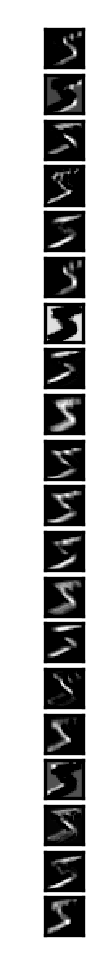

In [72]:
visualize_features_map(conv_output[0], n_filters=20, n_channels=1)

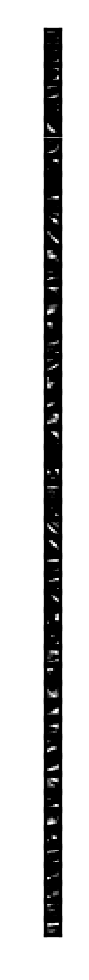

In [74]:
visualize_features_map(conv_output[1], n_filters=50, n_channels=1)